# When to stop measuring inputs?

(never, of course!)

In the paper, we propose to measure at least 25 inputs to have a key result working "in average". Don't get us wrong, this general threshold of 25 inputs will hold for the vast majority of software systems... 

... But won't be optimal!

- If the **input sensitivity is low** i.e. if the configuration options of the software system have the same effects for each input, few inputs will be enough for the machine learning model to understand the general effet of (interaction of) options. Imagemagick is definitely in this category; its optimal threshold to stop the measurements might be clearly under this value i.e. we'll need less inputs.

- On the opposite, for **highly input-sensitive systems** like nodejs or lingeling, the options are changing a lot. In this case, the model has not only to learn all the performance distributions of input profiles, but also how to discriminate inputs! Related work (e.g. Ding et al 2015 with Petabricks) sometimes separates these two tasks into two models, one to classify inputs and the other one to predict the performance distribution of a "profile" of input. 

So, we have two groups of software systems, input-stable and input-sensitive. For the first one, the general threshold given in the paper will be too high and the final user will lose time following our advice. For the second one, the number of inputs might be not sufficient to learn an accurate model and the prediction will be poor.

It also depends on the performance property we are predicting, since the software system can be sensible only for one particular performance property!

#### This notebook is there to detail the choice of threshold per couple of system and performance property. 

We rely on the results of the supervised offline approach (RQ3, figure 6).

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# gradient boosting trees
from xgboost import XGBRegressor

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")


from common import load_data, split_data

### We import the data to plot our results

In [2]:
# load the tabular data containing the results of RQ3
rq3 = pd.read_csv("../results/RQ3_data.csv").set_index("Unnamed: 0")

# list of software systems
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

inputs_perf = dict()
input_nb_list = dict()

# the list of performance properties for each software system
inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["size", "time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]

# the number of inputs per software system
input_nb_list["poppler"] = [2, 5, 10, 20, 50, 100, 200, 500, 800, 1000, 1300]
input_nb_list["imagemagick"] = [2, 5, 10, 20, 50, 100, 200, 500, 800]
input_nb_list["sqlite"] = [2, 5, 10, 20, 50, 75, 100, 120]
input_nb_list["lingeling"] = [2, 5, 10, 20, 50, 100, 150, 200]
input_nb_list["gcc"] = [2, 5, 10, 20, 25]
input_nb_list["nodejs"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000, 1500]
input_nb_list["xz"] = [2, 5, 10, 25, 30]
input_nb_list["x264"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000]

# the number of configs
valid_training_percentages = [(k+1)/10 for k in range(9)]
nb_configs = len(valid_training_percentages)

# to plot curves
linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
colors = ["gainsboro", "silver", "gray", "dimgray"]
markers = ['o', 's', 'p', 'x']

### Small function to show the results... almost done!

In [3]:
def show_res(ns, perf):
    ### input:
    #### ns the software
    #### perf the performance property

    #creates a dataframe with the results of the software system ns with the performance property perf
    df = rq3.query("soft=='"+ns+"'").query("perf=='"+perf+"'")

    res = dict()
    for i in range(df.shape[0]):
        res[df.iloc[i]['nb_config'], df.iloc[i]['nb_inputs']] = df.iloc[i]['mae']

    nb_inputs = len(input_nb_list[ns])

    mat = np.zeros(len(valid_training_percentages)*len(input_nb_list[ns])).reshape(len(valid_training_percentages),
                                                                              len(input_nb_list[ns]))
    for i in range(nb_configs):
        for j in range(nb_inputs):
            mat[i][j] = res[valid_training_percentages[i], input_nb_list[ns][j]]

    fig = plt.figure()
    axs = plt.subplot(111)
    fig.set_size_inches(10, 8)
    sns.heatmap(mat, vmin=0, vmax=1, cmap = "Greys", ax = axs,
                yticklabels=[10*k for k in range(1, 10)], xticklabels=input_nb_list[ns],
                cbar_kws={'label': 'MAE'})
    axs.figure.axes[-1].yaxis.label.set_size(20)
    axs.tick_params(axis='x', labelrotation= 90)
    axs.tick_params(axis='x', labelrotation= 90)
    axs.set_title(ns+' - '+perf, fontsize =25)
    axs.set_xlabel("# Inputs", size = 25)
    axs.set_ylabel("Configurations (% training)", size = 25)

    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.show()

    fig = plt.figure()
    axs = plt.subplot(111)
    fig.set_size_inches(10, 8)

    #[::-1]
    for i in range(mat.shape[1]):
        axs.plot(valid_training_percentages, mat[:, i], label = str(input_nb_list[ns][i])+" Inputs")

    axs.set_xticklabels([10*k for k in range(1, 10)])
    plt.xlabel("Configurations (% training)", size = 25)
    plt.ylabel("Mean Absolute Error (MAE)", size = 25)
    plt.grid()
    plt.legend(fontsize = 15)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.show()

# Results per software system
## And Performance property

# GCC

## compile time

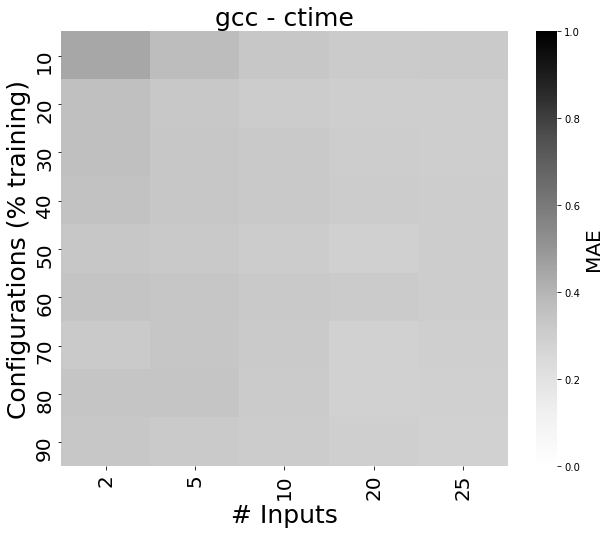

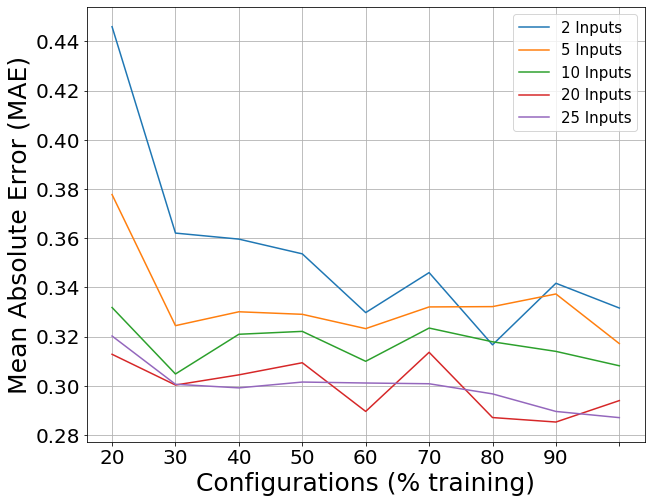

In [4]:
show_res("gcc", "ctime")

### For gcc and the execution time, the threshold is around 20 inputs so less than 25

## execution time

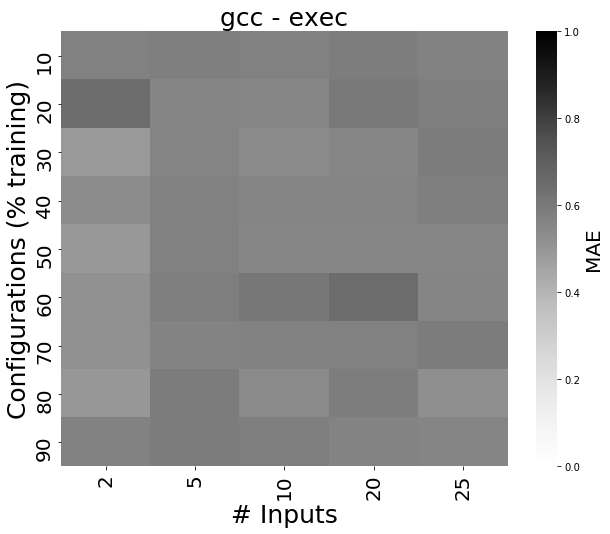

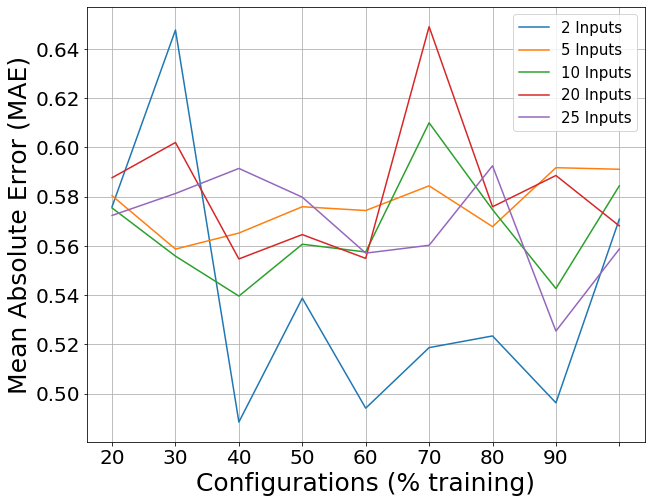

In [5]:
show_res("gcc", "exec")

### for gcc and execution, it does not seems to progress with the added inputs, which suggests the threshold is probably higher than 25

## size

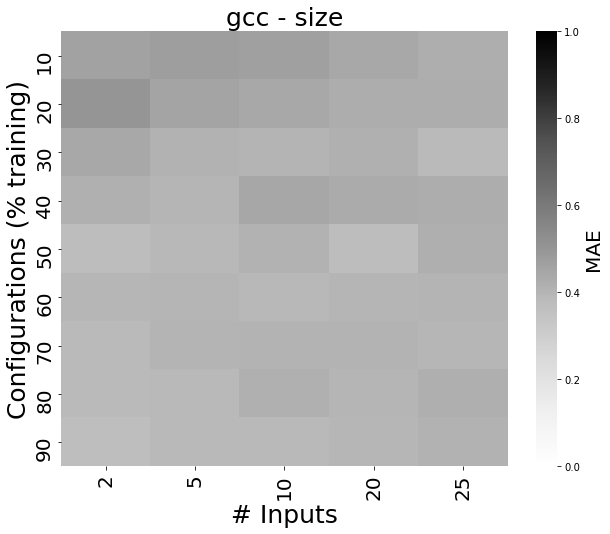

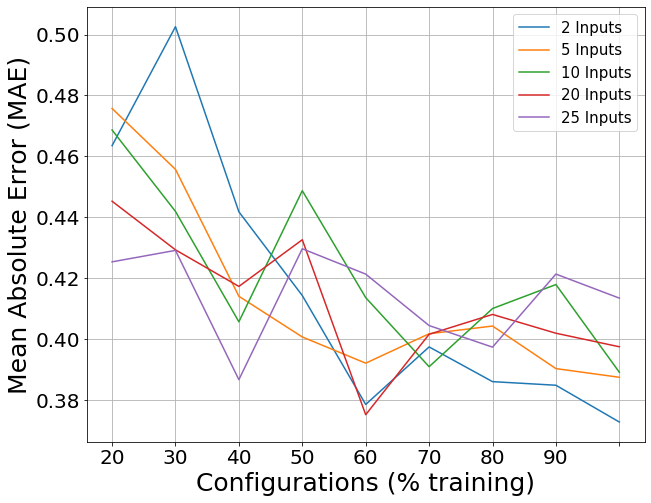

In [6]:
show_res("gcc", "size")

### Same for the size, would be good to add more inputs -> threshold > 25

# Imagemagick

## Time

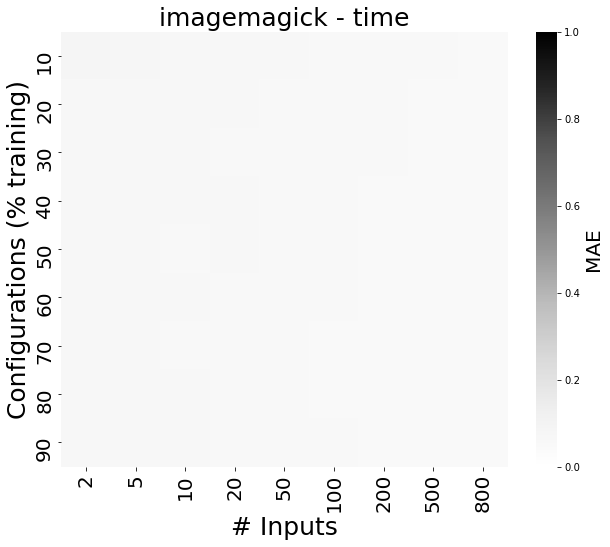

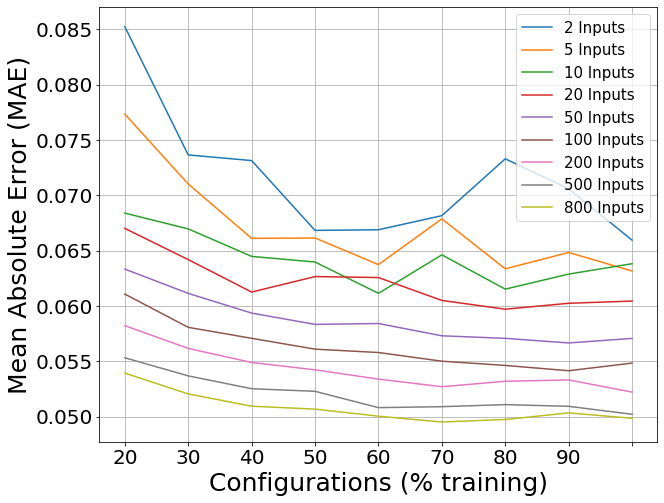

In [7]:
show_res("imagemagick", "time")

### 10 inputs are already enough

# Lingeling

## conflicts

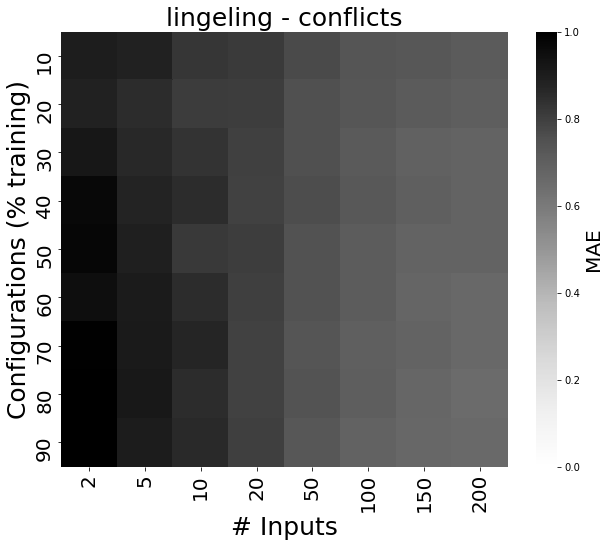

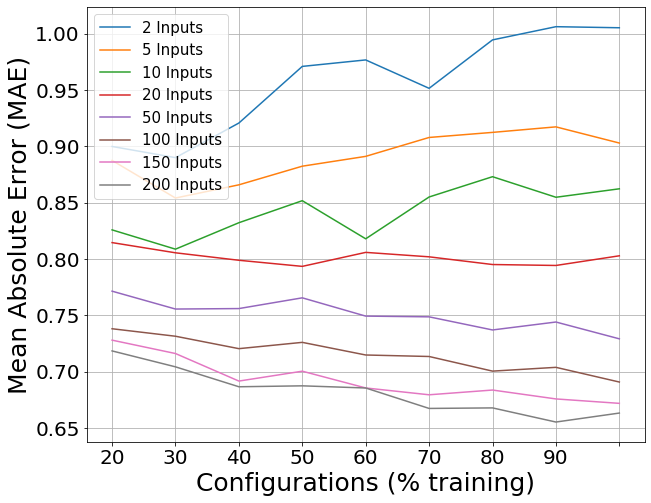

In [8]:
show_res("lingeling", "conflicts")

### For lingeling, it is a complex case, would be good to consider at least 150 inputs. it seems to stabilise after this but not so sure, could deserve additional inputs to validate

## conflicts per second

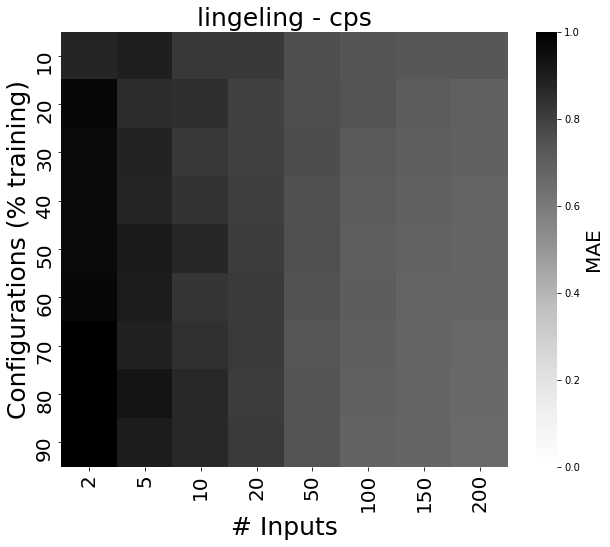

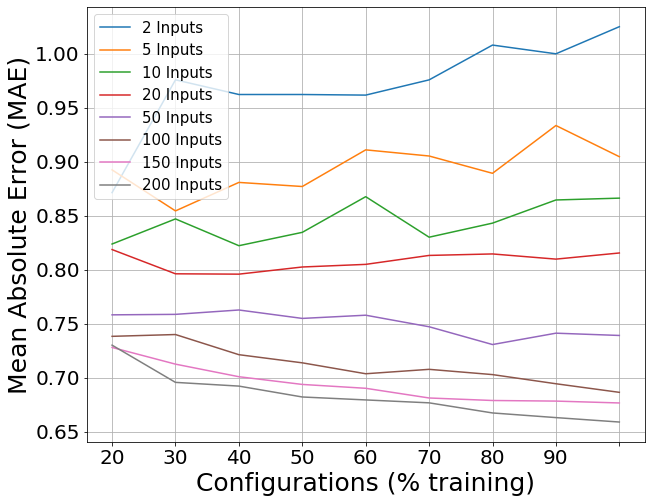

In [9]:
show_res("lingeling", "cps")

### We guess the threshold is between 100 and 150

## reductions

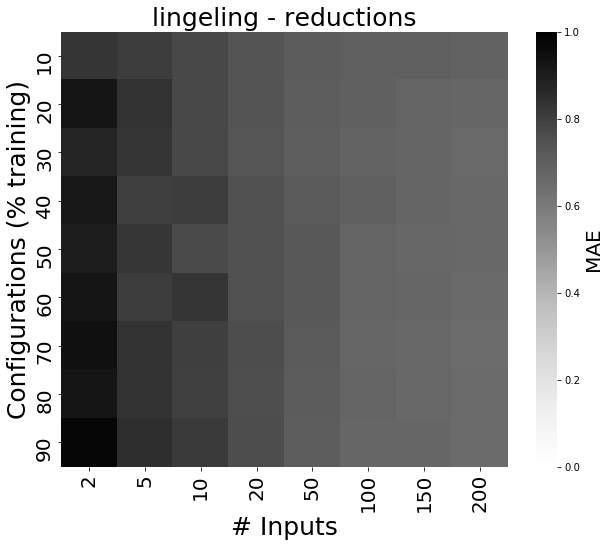

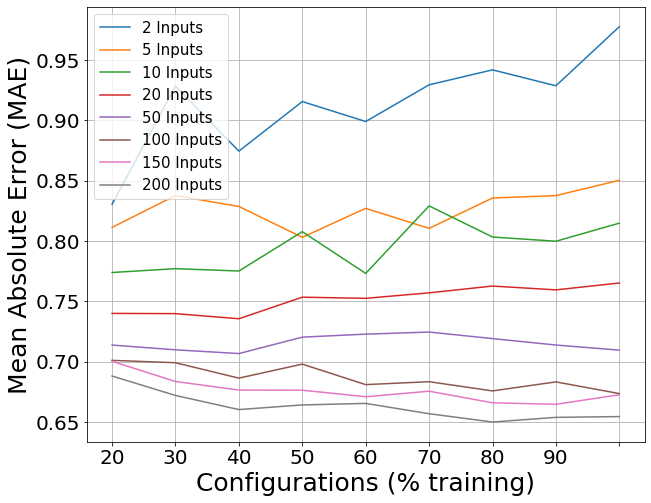

In [10]:
show_res("lingeling", "reductions")

### Threshold around 100

# NodeJS

## number of operations per second

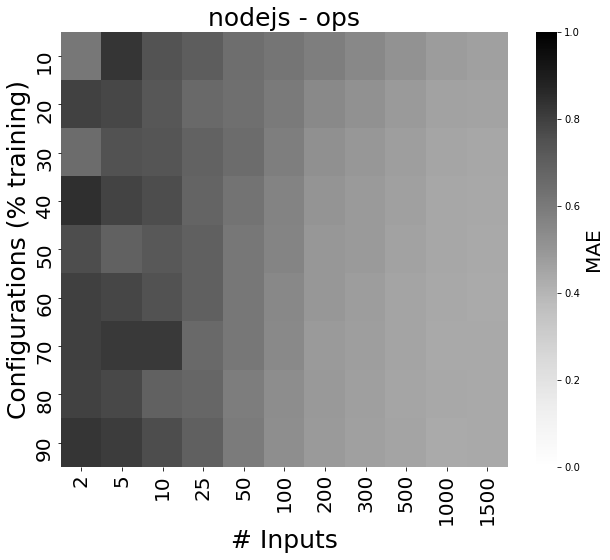

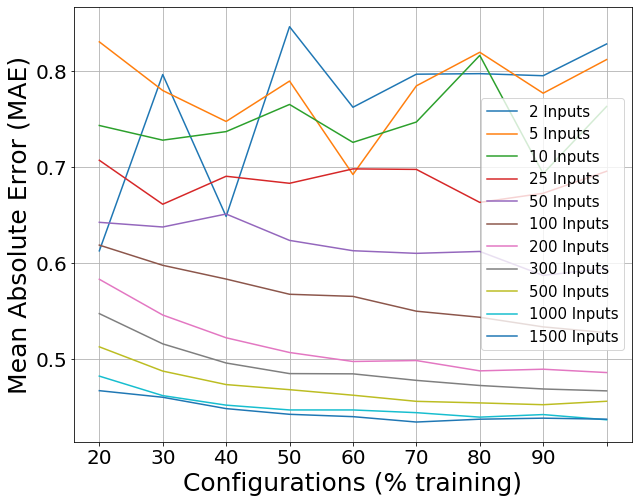

In [11]:
show_res("nodejs", "ops")

### A threshold at 50-100 seems correct here

# Poppler

## size

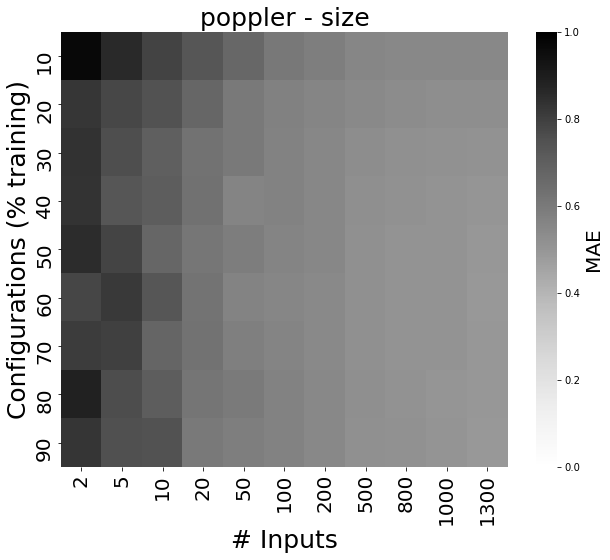

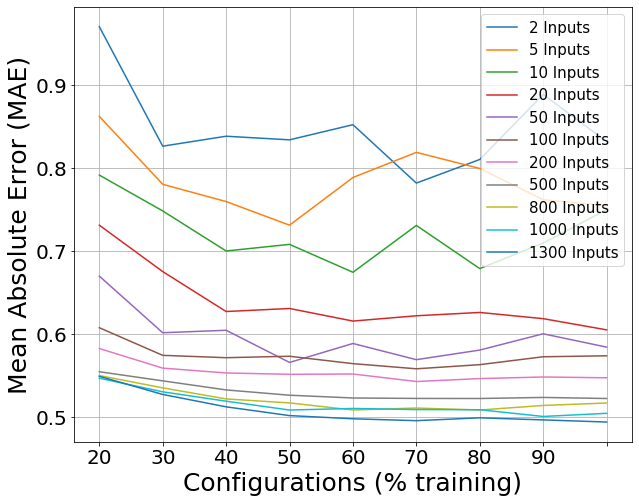

In [12]:
show_res("poppler", "size")

### Threshold around 20 ? 

## time

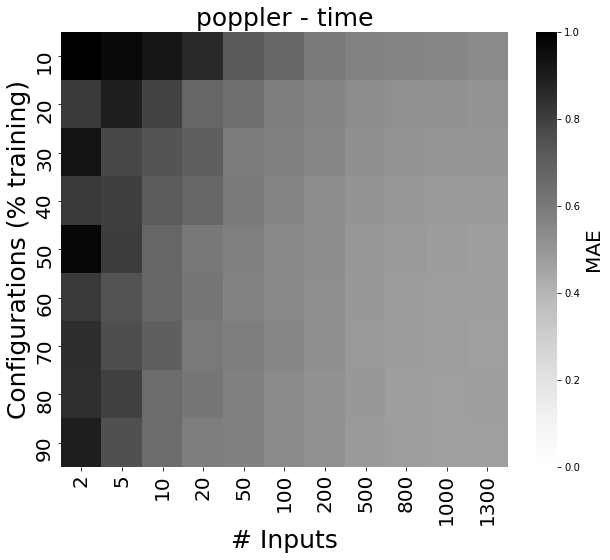

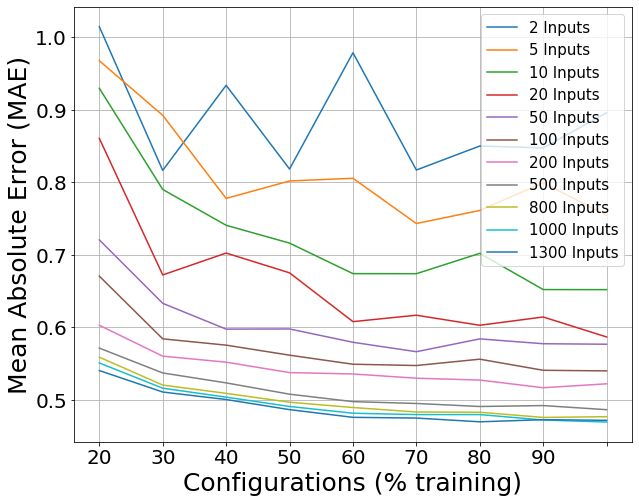

In [13]:
show_res("poppler", "time")

### Same for the time of poppler, threshold around 20

# SQLite

## q1

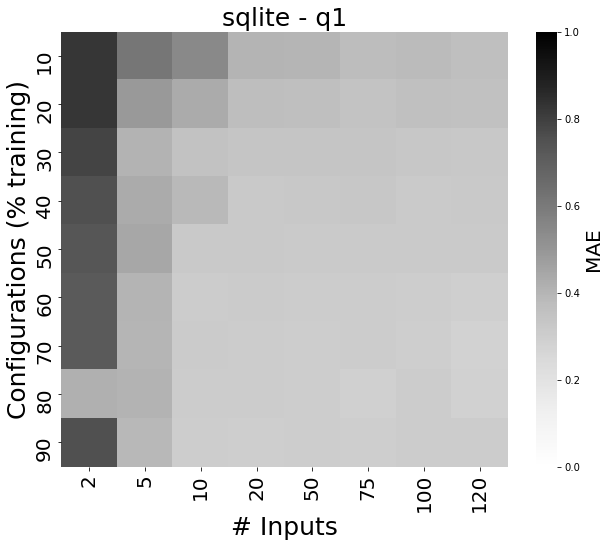

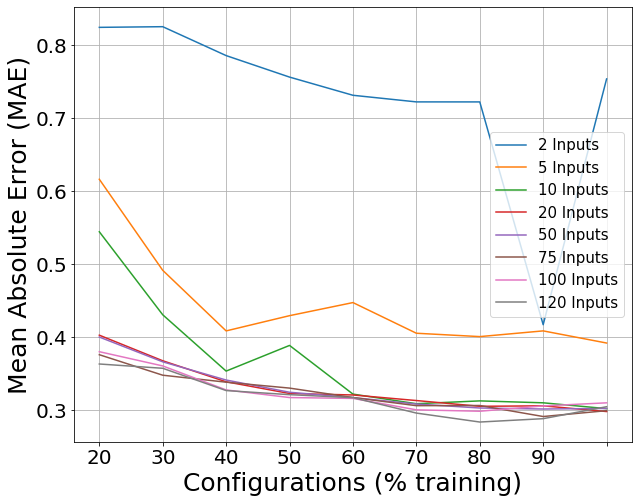

In [14]:
show_res("sqlite", "q1")

### Threshold at 10 for all queries of SQLite

## q2

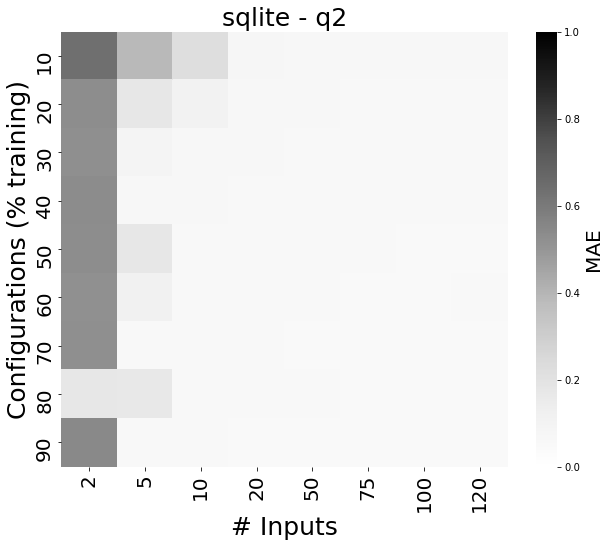

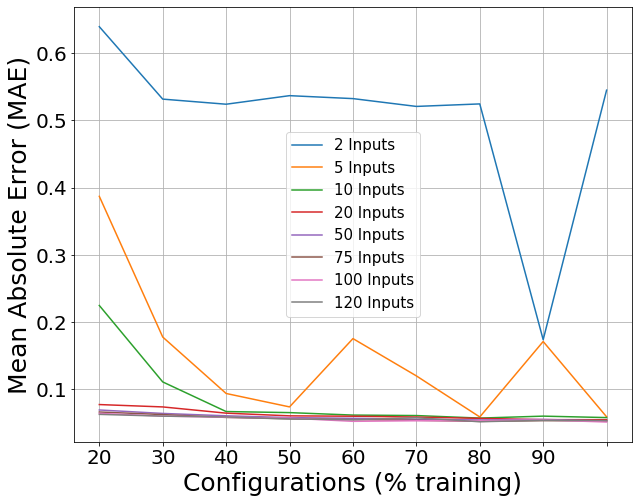

In [15]:
show_res("sqlite", "q2")

## q3

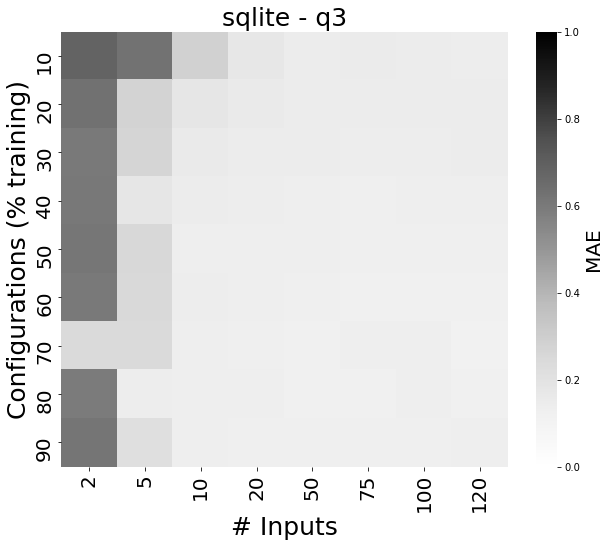

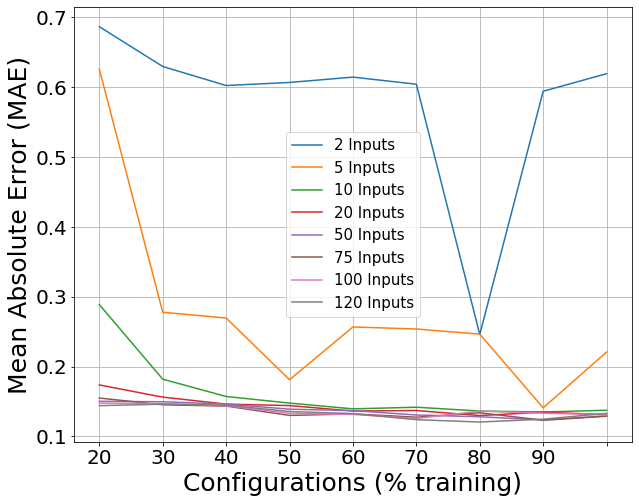

In [16]:
show_res("sqlite", "q3")

## q4

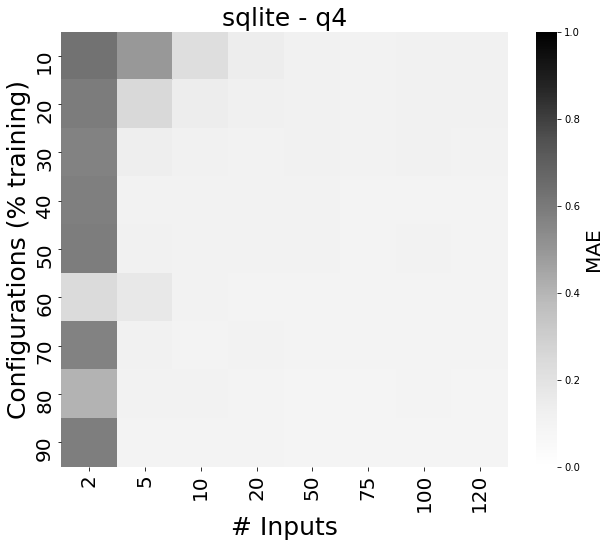

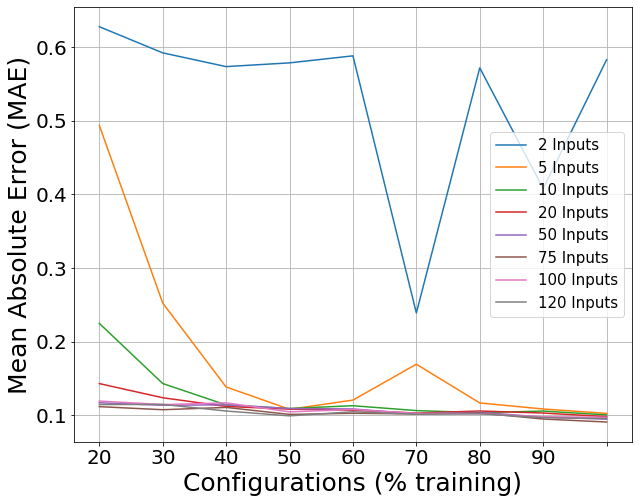

In [17]:
show_res("sqlite", "q4")

## q5

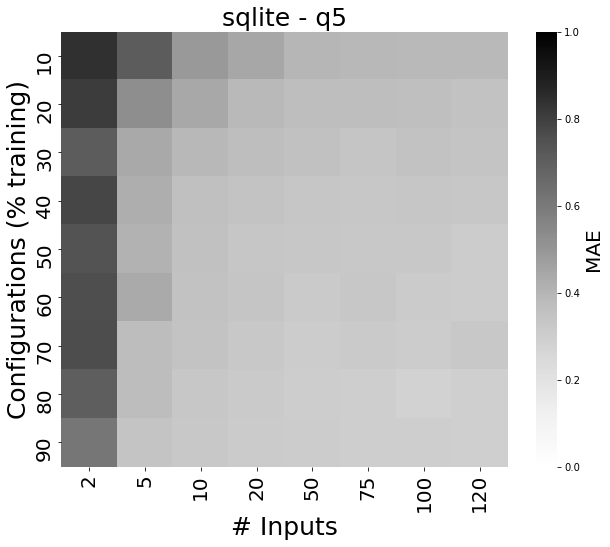

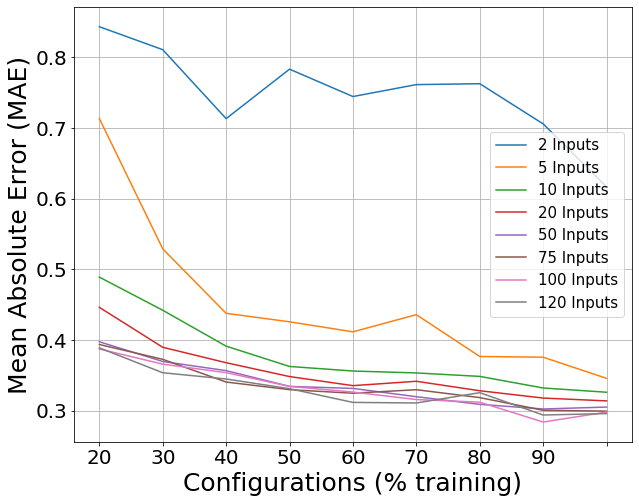

In [18]:
show_res("sqlite", "q5")

### Maybe 20 for this case?

## q6

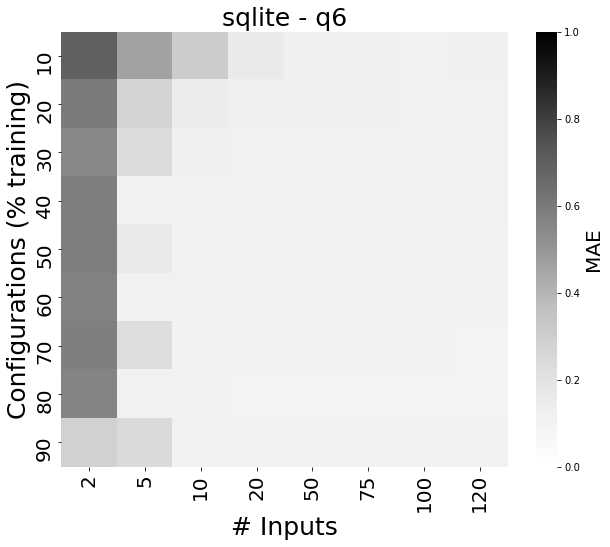

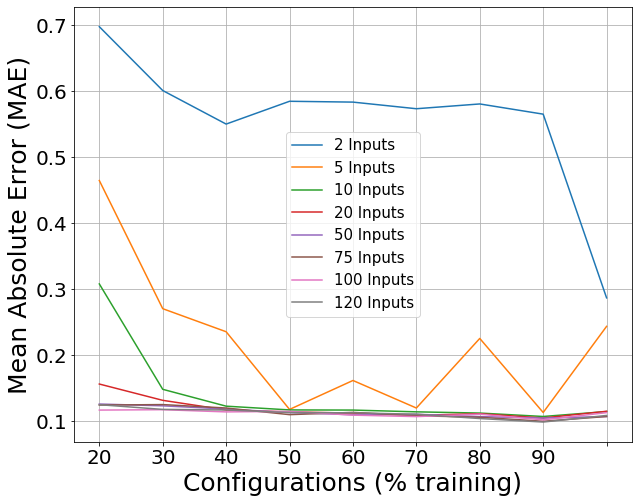

In [19]:
show_res("sqlite", "q6")

## q7

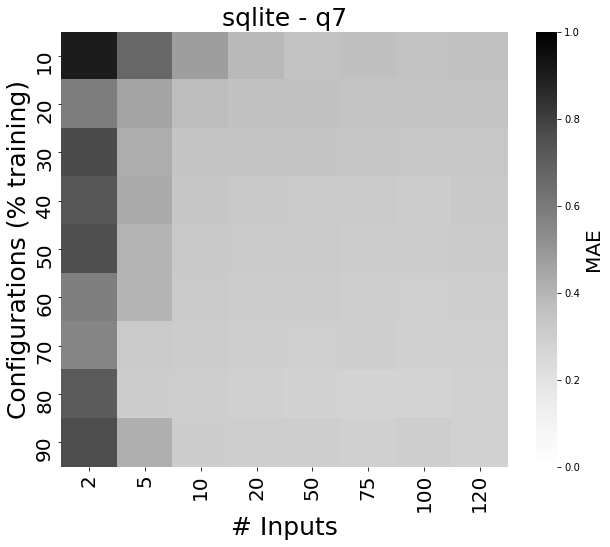

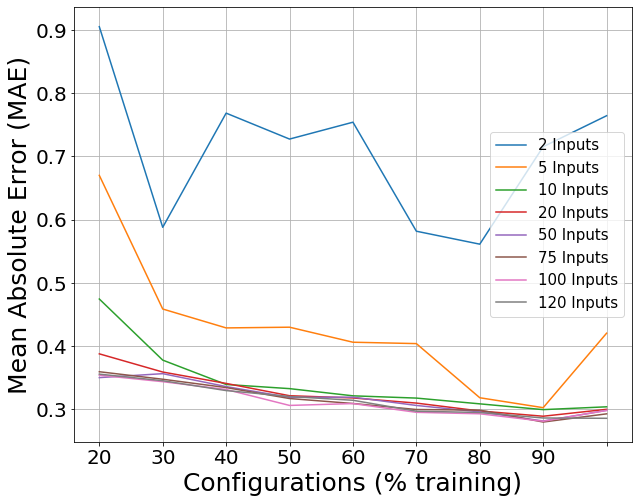

In [20]:
show_res("sqlite", "q7")

## q8

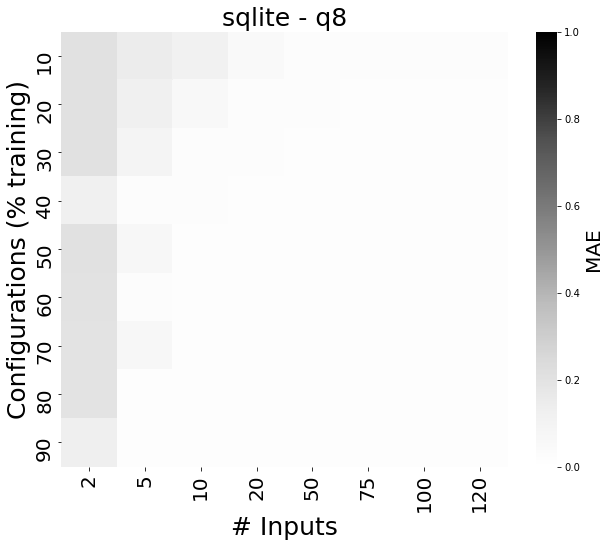

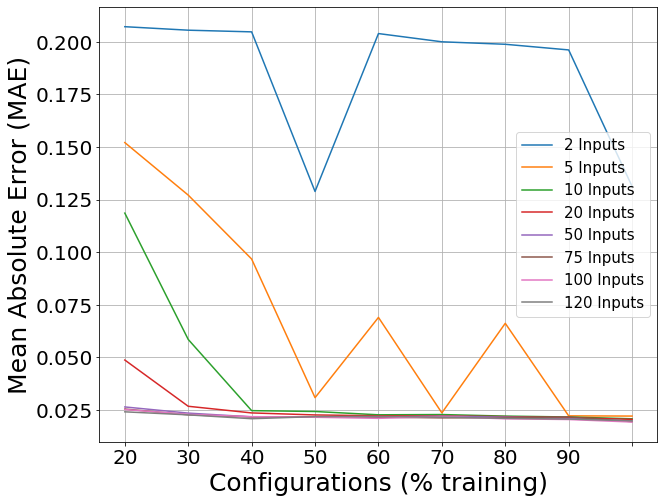

In [21]:
show_res("sqlite", "q8")

## q9

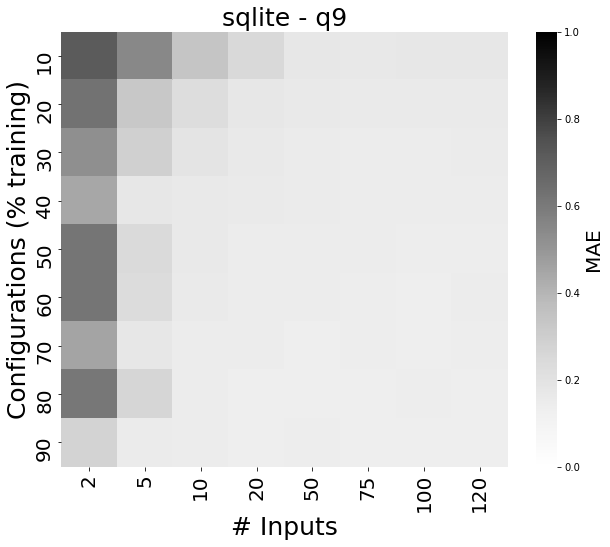

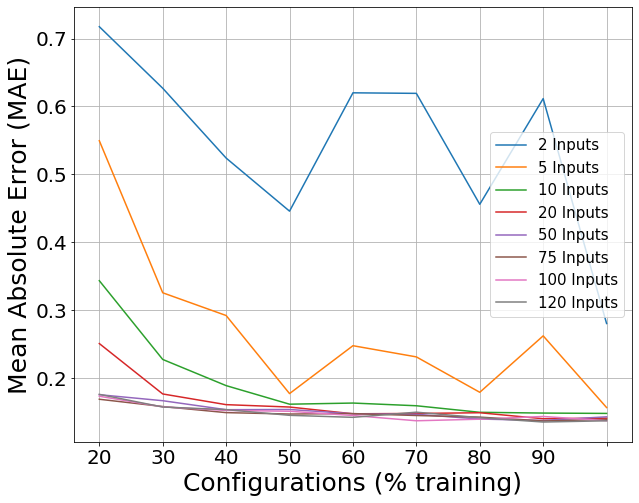

In [22]:
show_res("sqlite", "q9")

## q10

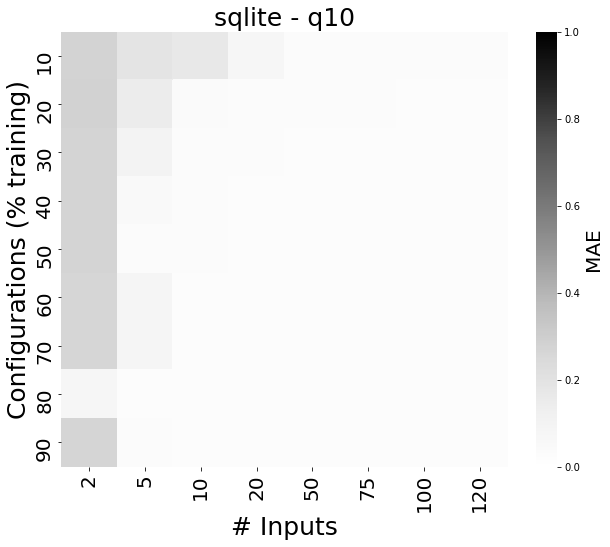

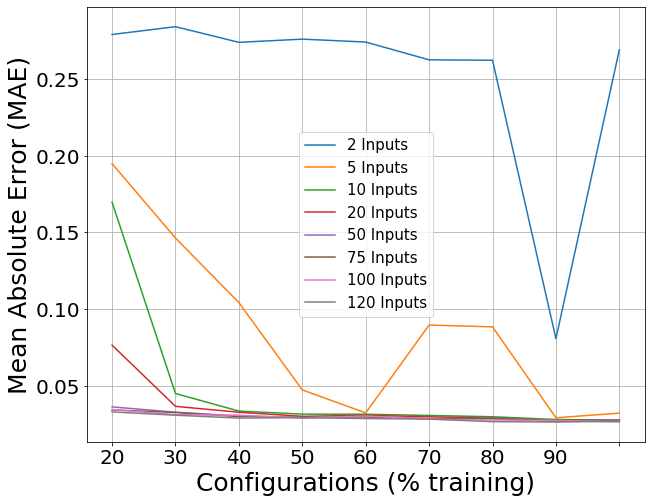

In [23]:
show_res("sqlite", "q10")

## q11

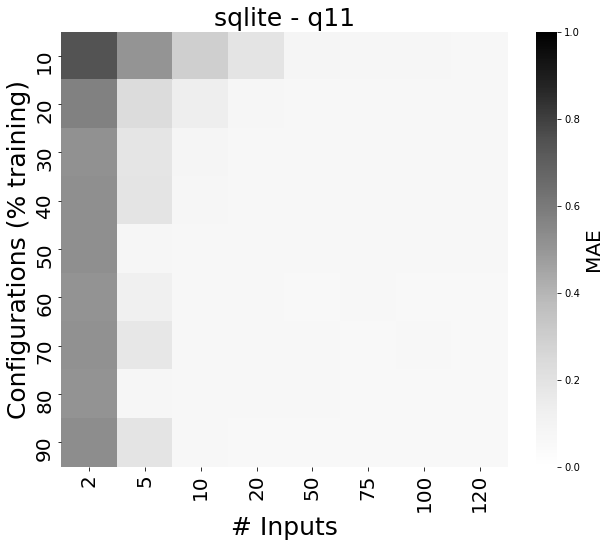

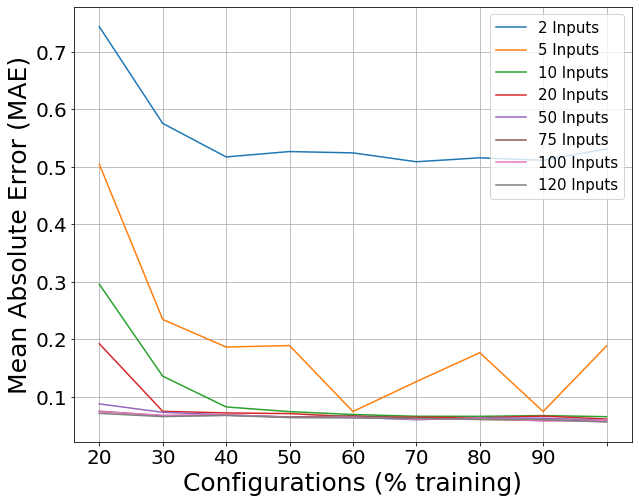

In [24]:
show_res("sqlite", "q11")

## q12

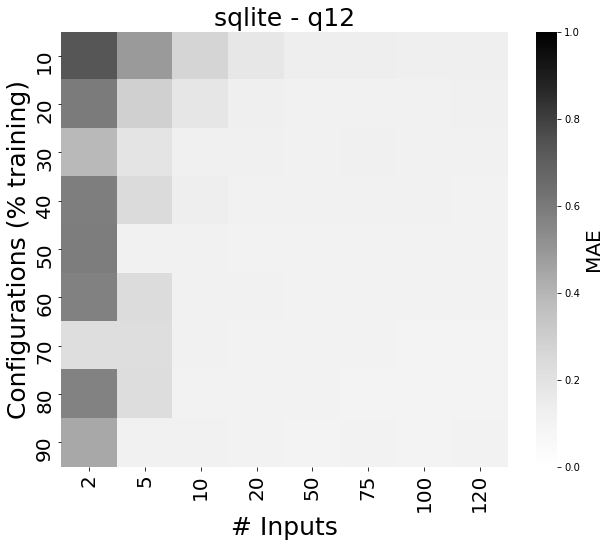

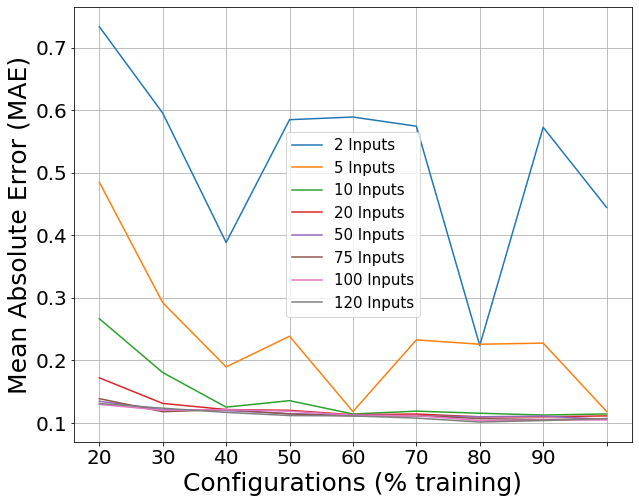

In [25]:
show_res("sqlite", "q12")

## q13

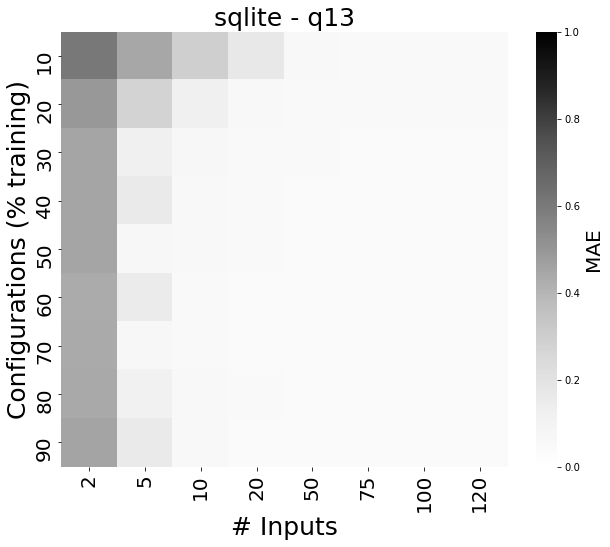

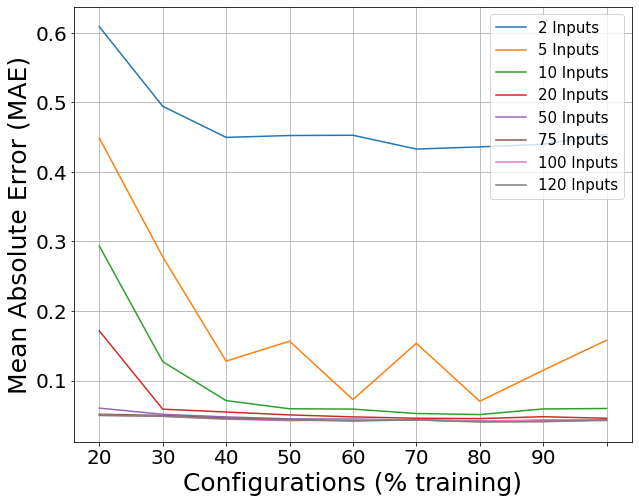

In [26]:
show_res("sqlite", "q13")

 ## q14

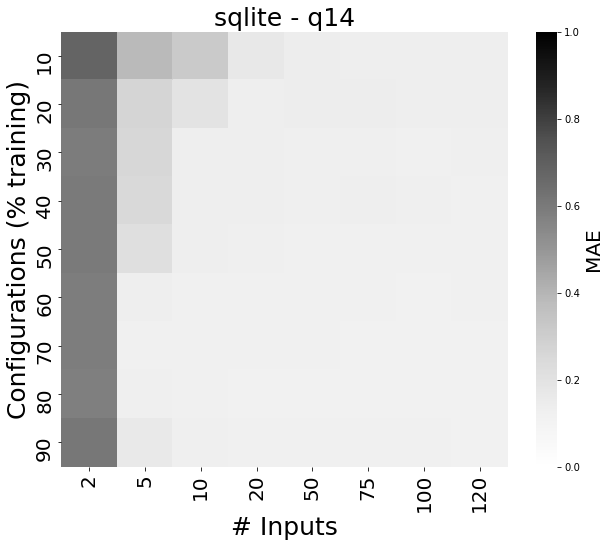

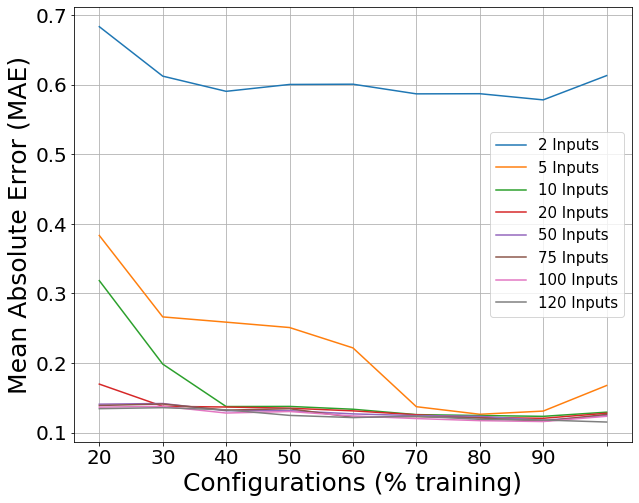

In [27]:
show_res("sqlite", "q14")

## q15

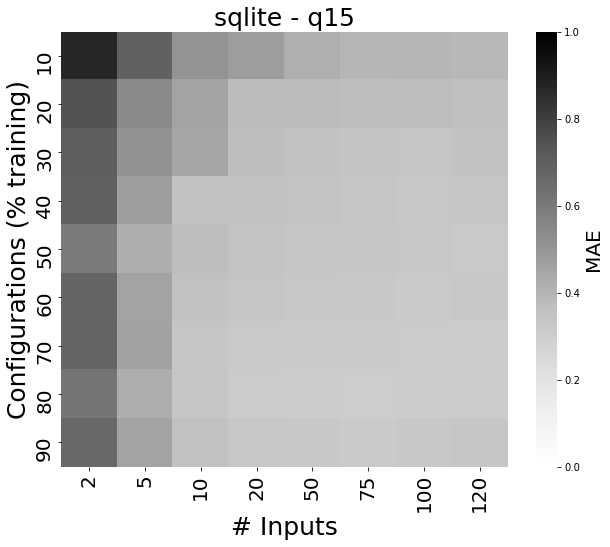

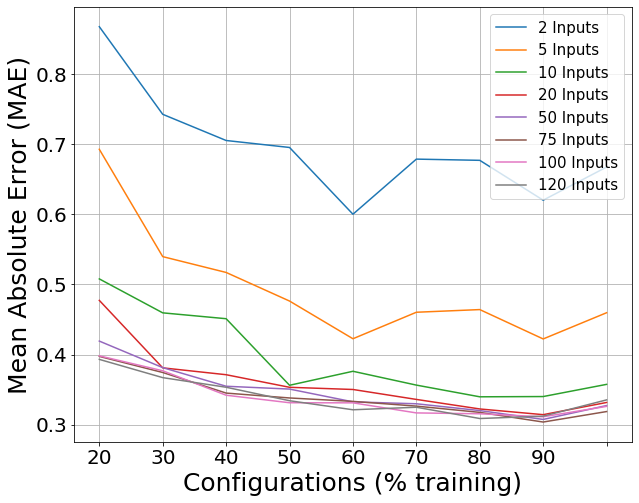

In [28]:
show_res("sqlite", "q15")

# xz

## time

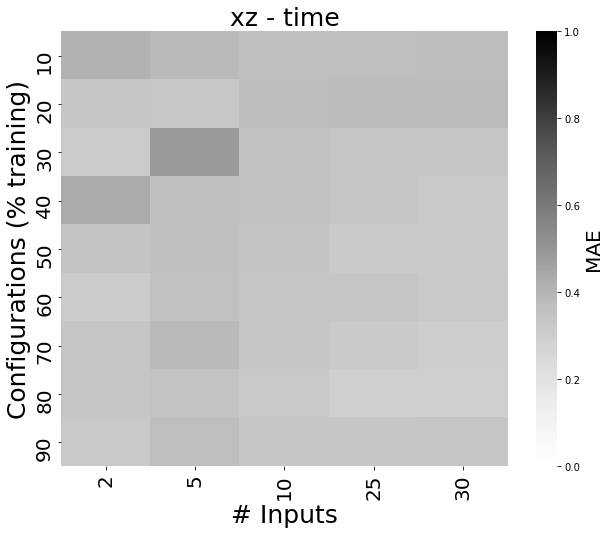

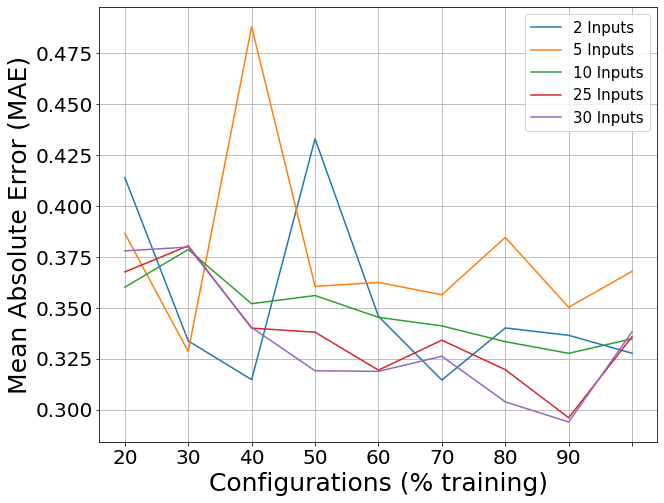

In [29]:
show_res("xz", "time")

### Same conclusion as gcc - we should continue to measure to be sure, but it does not improve the prediction to add inputs for now

# x264

## bitrate

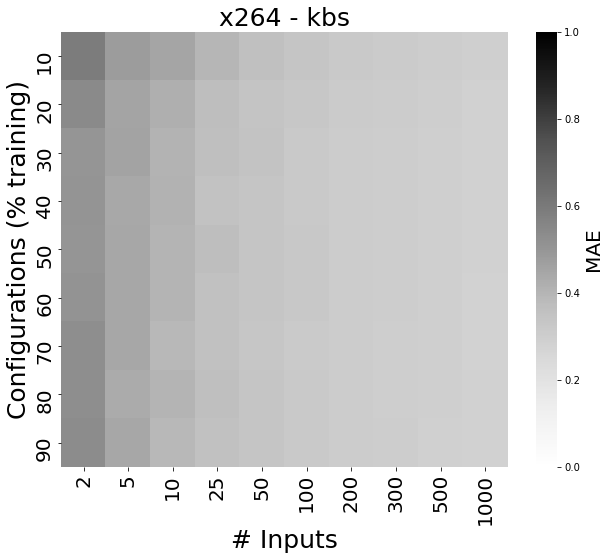

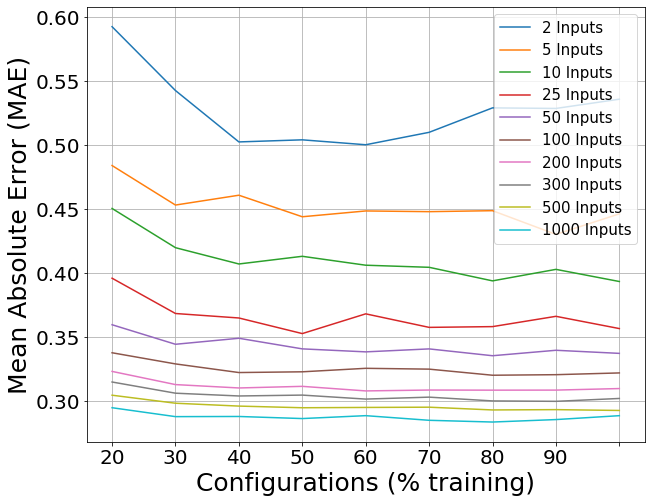

In [30]:
show_res("x264", "kbs")

### 25 inputs is enough to get a correct estimation

## frame encoded per second

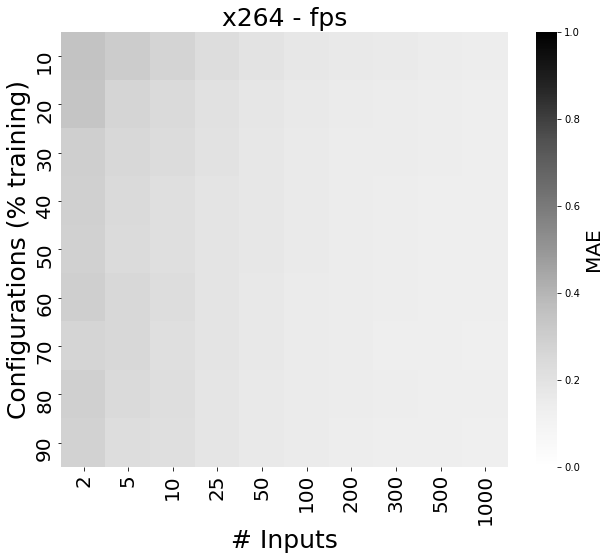

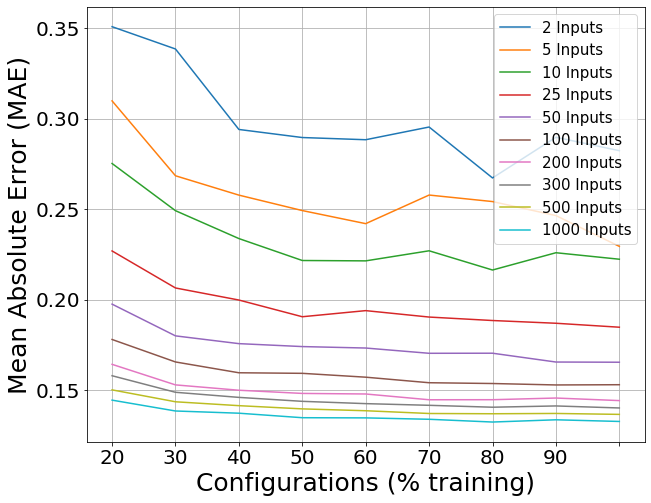

In [31]:
show_res("x264", "fps")

### Same here, let's keep the general threshold

## CPU usage

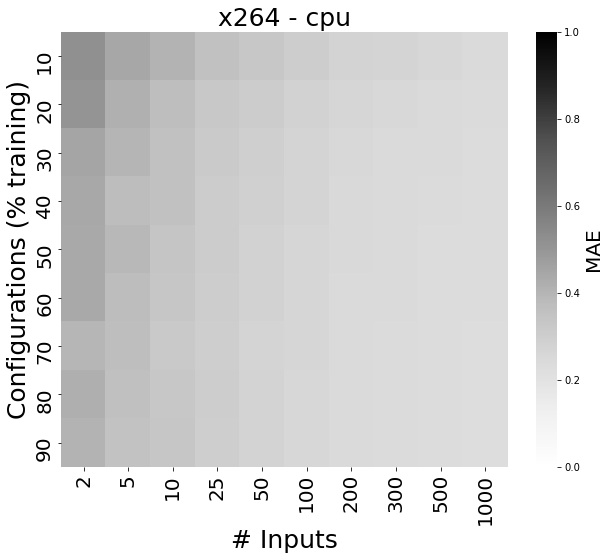

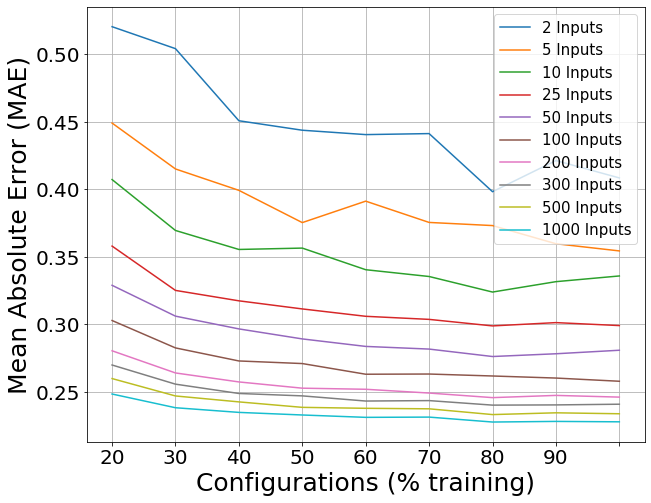

In [32]:
show_res("x264", "cpu")

### Same, 25!

## Encoded size of video

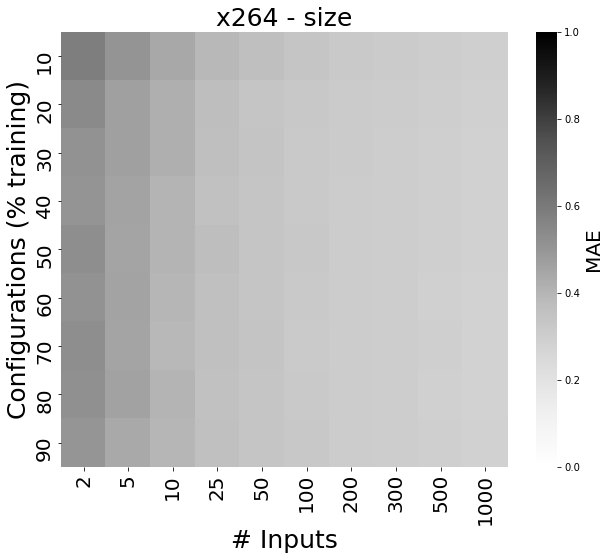

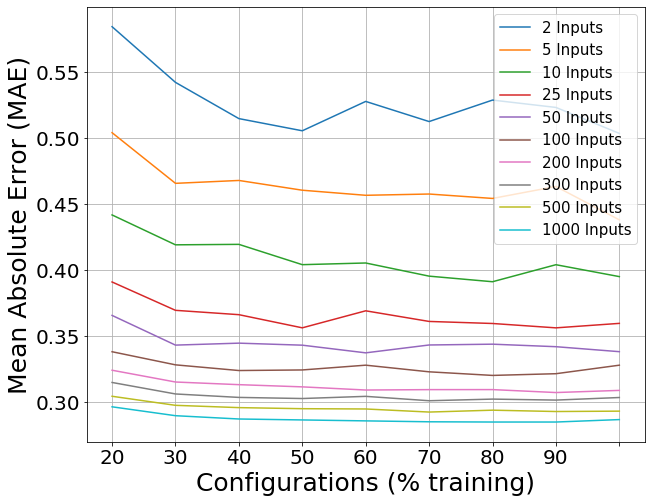

In [33]:
show_res("x264", "size")

### not really changing

## Encoding time

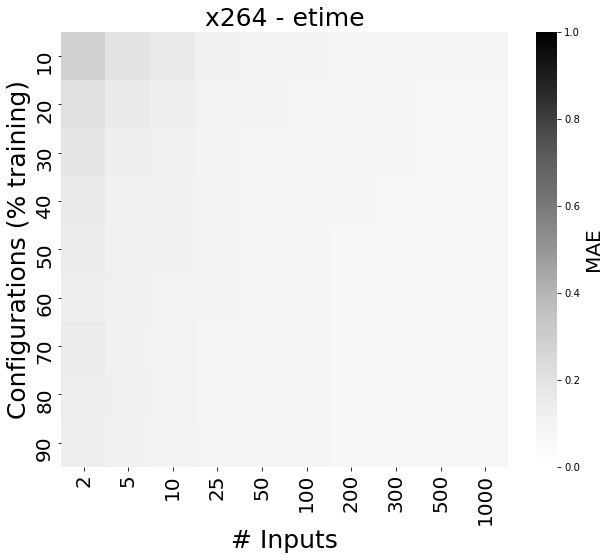

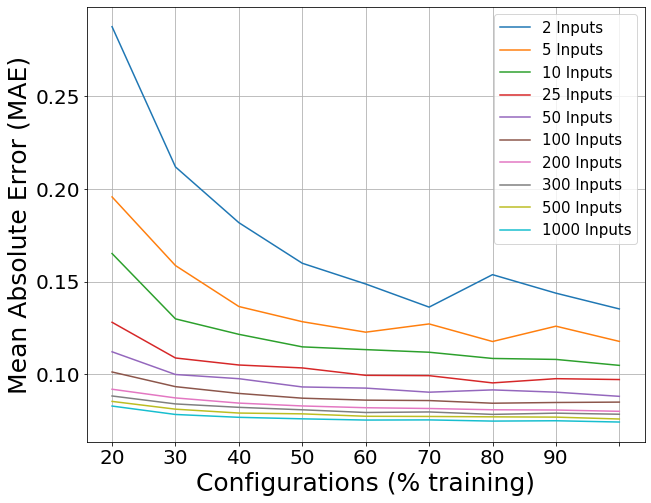

In [34]:
show_res("x264", "etime")

### 10 inputs are ok